# A sinusoidal weight matrix robust to non sinusoidal inputs

<!-- * If we want a circulant network to have stable activity with no input
* and the network is operating in the linear regime
* and the network needs to encode 2 variables (vector direction and magnitude)
* and the neurons can only have positive activities

Then the solution which provides the optimal noise resilience is:
* activity is a sinusoid with period equal to the number of neurons, and minimum of 0
* weight matrix is a also a sinusoid with nonzero mean (ie. Fourier modes 0 and 1 are non-zero)

Results:
* increasing the number of Fourier modes present in the weight matrix after the first 2 which are required increases the resulting noise linearly
  * having only Fourier modes 0 and 1 allows the weight matrix to perform low pass filtering on the noise - reject most of it
* increasing the number of neurons in the network allows for better noise rejection -->

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn')
np.random.seed(7) # seed so plots are repeatable

In [48]:
N = 32
neuron_indices = np.arange(N)
scaled_cosine = lambda neuron_indices, N: (1 + np.cos(2*np.pi*neuron_indices/N))/2
gaussian = lambda neuron_indices, N: np.exp(-(neuron_indices - N/2)**2 /4)

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_modes = lambda fourier_modes: np.fft.ifft(np.hstack((fourier_modes, np.flip(fourier_modes[1:-1])))).real

a = scaled_cosine(neuron_indices, N)

In [49]:
def simulate_and_plot(a0, W, dt=0.001, u=None, repetitions=100, noise=0.3, plot=True, show=True):
	a = np.tile(a0, (repetitions,1)).T
	a += noise*np.random.randn(*a.shape)

	# simulate for 50000 time steps
	if u is None:
		for _ in range(50000):
			delta_a = -a + W@a
			a += dt*delta_a
	else:
		u = u.reshape(a0.size,1)
		for _ in range(50000):
			delta_a = -a + W@a + u
			a += dt*delta_a

	error = a - a0.reshape(a0.size,1)
	mu = a.mean(axis=1)
	stdev = np.sqrt(a.var(axis=1))
	rms = np.sqrt((error**2).mean(axis=1))
	rms_mean = rms.mean()
	rms_stdev = np.sqrt(rms.var())

	if plot:
		plt.fill_between(neuron_indices, mu - stdev, mu + stdev, alpha=0.5, label='response stddev')
		plt.plot(neuron_indices, a[:,0], 'orange', label='example response')
		plt.plot(a0, 'k', label='original activity')
		plt.title(f'Average RMS error = {rms_mean:.4f}')
		plt.legend()
		if show:
			plt.show()

	return rms_mean, rms_stdev

## Test how adding more Fourier modes effects the error

Normal stable network


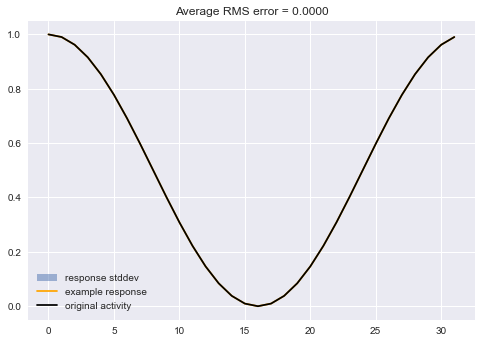

constant input (DC offset) - unstable


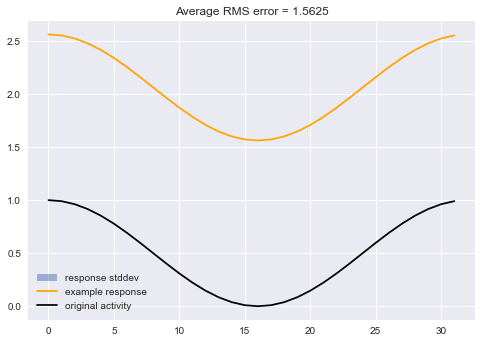

pure sinusoidal input - unstable


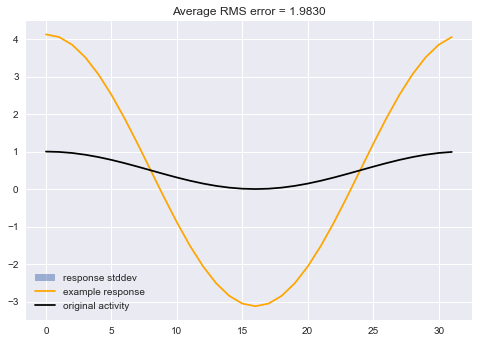

input with frequency 4 times the fundamental


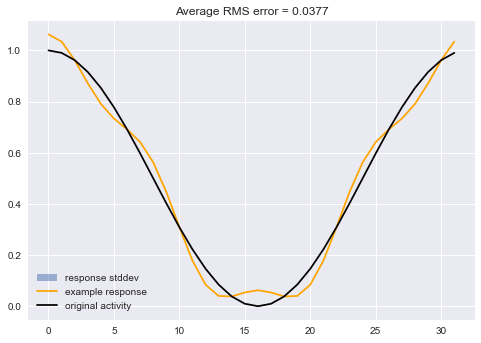

(0.037722086912052394, 0.023025402471982807)

In [50]:
noise_stddev = 0

W = profile_to_matrix(get_cosine_from_fourier_modes([1]*2 + [0]*(N//2+1-2)))

print('Normal stable network')
simulate_and_plot(a, W, repetitions=1, noise=noise_stddev)

print('constant input (DC offset) - unstable')
simulate_and_plot(a, W, repetitions=1, noise=noise_stddev, u = get_cosine_from_fourier_modes([1] + [0]*(N//2+1-1)))

print('pure sinusoidal input - unstable')
simulate_and_plot(a, W, repetitions=1, noise=noise_stddev, u = get_cosine_from_fourier_modes([0, 1] + [0]*(N//2+1-2)))

print('input with frequency 4 times the fundamental')
simulate_and_plot(a, W, repetitions=1, noise=noise_stddev, u = get_cosine_from_fourier_modes([0]*4 + [1] + [0]*(N//2+1-5)))